In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
parent_df = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_new_visitor_level.csv",dtype={"fullVisitorId":"str"})

In [3]:
columnsToDrop = ["fullVisitorId","returnedPostGap","totals_transactionRevenue_LogOfSum"]

In [4]:
X_cls = parent_df.drop(columns=columnsToDrop,axis=1)
Y_cls = parent_df["returnedPostGap"]

In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
tscv = TimeSeriesSplit(n_splits=10)  # defining the time-series split

# time-series cross-validation iterator for classification.
cv_iterator_cls = []
for train_indices,test_indices in tscv.split(X=X_cls, y=Y_cls):
  # print(train_indices,train_indices.shape)
  # print(test_indices,test_indices.shape)
  # print()
  cv_iterator_cls.append( (train_indices,test_indices) )

In [6]:
cv_iterator_cls[9][1] # the last split's test indices
# These indices were never seen by the model during training. Hence, this is THE PERFECT testing dataset for post-training-analysis.
# Its corresponding training indices can hence be used as train set.

array([1288705, 1288706, 1288707, ..., 1417572, 1417573, 1417574])

In [7]:
print("Train:-")
trainX = X_cls.iloc[cv_iterator_cls[9][0]]
trainY = Y_cls.iloc[cv_iterator_cls[9][0]]
print(trainX.shape)
print(trainY.shape)
print()
print("Test:-")
testX = X_cls.iloc[cv_iterator_cls[9][1]]
testY = Y_cls.iloc[cv_iterator_cls[9][1]]
print(testX.shape)
print(testY.shape)

Train:-
(1288705, 116)
(1288705,)

Test:-
(128870, 116)
(128870,)


In [11]:
# Resource: AAIC assignment
def compute_best_threshold(thresholds,fpr,tpr):
  """Returns the best threshold index which will give us: 1. least FPR & 2. highest TPR"""
  return thresholds[ np.argmax(tpr * (1-fpr)) ]

def predict_labels_basis_best_threshold(tau, probscores):
  """Returns the labels --> basis this 'best threshold'"""
  pred_labels = []
  for el in probscores:
    if el >= tau:
      pred_labels.append(1)
    else:
      pred_labels.append(0)
  return pred_labels

In [12]:
def get_file(f_path):
  """Takes path & returns the data present in that file"""
  data = pickle.load( open(f_path,"rb") )
  return data
f_path = "/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.1/gbdt_cls_model.sav"
loaded_model_cls = get_file(f_path) 

In [13]:
train_prob_scores = loaded_model_cls.predict_proba(trainX)[:,1] # probability of a point belonging to class 1.
fpr, tpr, tau = roc_curve(trainY, train_prob_scores)
# Computing the best threshold which will give us: 1. least FPR & 2. highest TPR
best_tau = compute_best_threshold(tau, fpr, tpr)
print(f"Best threshold obtained via train set predictions is= {best_tau}")

# Let's now predict the labels in test set using the above obtained best threshold --> best_tau
test_prob_scores = loaded_model_cls.predict_proba(testX)[:,1] # probability of a point belonging to class 1.
testY_pred = predict_labels_basis_best_threshold(best_tau, test_prob_scores)

Best threshold obtained via train set predictions is= 0.005727777723222971


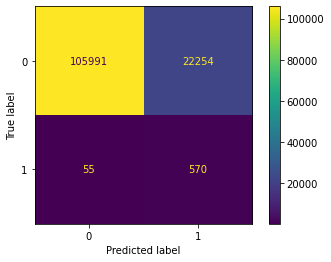

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(testY, testY_pred, labels=loaded_model_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_model_cls.classes_)
disp.plot()
plt.show()

In [57]:
print("TPR:",cm[1,1]/(cm[1,0]+cm[1,1]))
print("TNR:",cm[0,0]/(cm[0,0]+cm[0,1]))
print("FPR:",cm[0,1]/(cm[0,0]+cm[0,1]))
print("FNR:",cm[1,0]/(cm[1,0]+cm[1,1]))
print("AUC:",roc_auc_score(testY,test_prob_scores))
print("%age mis-classifications:",((cm[0,1]+cm[1,0])/testX.shape[0])*100,"%")
print("%age correct-classifications:",((cm[0,0]+cm[1,1])/testX.shape[0])*100,"%")

TPR: 0.912
TNR: 0.8264727669694725
FPR: 0.1735272330305275
FNR: 0.088
AUC: 0.9418672821552497
%age mis-classifications: 17.31124388919066 %
%age correct-classifications: 82.68875611080935 %


<font color="#a020f0"> Comments:-
* The good thing here is: for the test dataset we are using here, for our post-training analysis has quite a good AUC score of 0.94. It means, the model has very much capable of predicting correctly. Now, for a data, which is so imbalanced, AUC we are getting here is quite good.
* In this problem, what's more risky is a high FPR: means, predicting that a customer actually came back when in reality she/he didn't. That's because, this would lead to the marketing team investing for promotions for customers who won't return only and hence, generating no revenue at all! This would simply lead to wastage of millions!
* And here, as per the results obtained above, FPR is 0.17 which is not that high. And hence, the model is quite good!</font>
* <font color="#8fce00">Also, all these observations will surely improve for the actual test dataset we've been provided with, which has data on 296530 vistors (the above observations are just for 128870 datapoints). But since we don't have the ACTUAL INSIGHTS on the ACTUAL labels for these customers (it is for a future of 1st Dec, 2018 to 31st Jan,2019; it is kept private by Kaggle), we can't analyse for these points.</font>



---

---





---



<font color="#a020f0">A new dataframe containing 3 columns: row-indices in the test set we used here, the actual and predicted values.</font>

In [16]:
df = pd.DataFrame({"row_index":testY.index,
                   "y_true":testY.values,
                   "y_pred":testY_pred})

<font color="#a020f0">Separating into 2 child dataframes from the above dataframe: 1 containing correctly predicted rows and the other, incorrectly predicted ones.</font>

In [17]:
df1 = df[ df['y_true'] == df['y_pred'] ]
print("correct results df shape:",df1.shape)
df2 = df[ df['y_true'] != df['y_pred'] ]
print("incorrect results df shape:",df2.shape)

correct results df shape: (106561, 3)
incorrect results df shape: (22309, 3)


In [18]:
df1.head(2)

,row_index,y_true,y_pred
0,1288705,0,0
1,1288706,0,0


In [19]:
df2.head(2)

,row_index,y_true,y_pred
5,1288710,0,1
13,1288718,0,1


<font color="#a020f0">Constructing 2 sub-dataframes from the parent test dataframe we used here, using the row-indices obtained above.</font>

In [20]:
def get_row(x,y):
  if y=="c":
    if x in df1['row_index'].values:
      return x
  if y=="i":
    if x in df2['row_index'].values:
      return x
cor_idx = pd.Series(testX.index).apply(get_row, args=("c",)).dropna()
incor_idx = pd.Series(testX.index).apply(get_row, args=("i",)).dropna()

In [21]:
# SANITY.
print( list(cor_idx) == list(df1['row_index'].values) )
print( list(incor_idx) == list(df2['row_index'].values) )

True
True


In [22]:
# THE CORRECT RESULTS DATAFRAME
correct_results_df = parent_df.loc[list(cor_idx)].drop(columns=['totals_transactionRevenue_LogOfSum'],axis=1)
# THE INCORRECT RESULTS DATAFRAME
incorrect_results_df = parent_df.loc[list(incor_idx)].drop(columns=['totals_transactionRevenue_LogOfSum'],axis=1)
# THE MAIN TEST DATAFRAME
parent_test = parent_df.iloc[cv_iterator_cls[9][1]].drop(columns=['totals_transactionRevenue_LogOfSum'],axis=1)

<font color="#a020f0">Let's now create a re-usable function to get insights on the data-points differ in the CORRECTLY predicted dataset & INCORRECTLY predicted dataset from the parent TEST dataset.<br>
NOTE: Class-0 indicates that the customer didn't return post the gap-period and Class-1 indicates that the customer did.</font>

In [55]:
# https://www.w3schools.com/python/ref_string_format.asp#:~:text=any%20data%20type.-,The%20Placeholders,-The%20placeholders%20can
def get_insights(feature):
  """Takes in feature name and plots 3 plots using 3 different datasets: the actual TEST dataset we used here for post-training analysis,
  the CORRECTLY predicted points' dataset and the INCORRECTLY predicted points' dataset."""
  plt.figure(figsize=(20,5))
  sns.set_theme(style="whitegrid")

  plt.subplot(1,3,1)
  t = "Box Plot of {f_name} in TEST dataset".format(f_name=feature)
  plt.title(t)
  sns.violinplot(data=parent_test, y=parent_test[feature], x=parent_test['returnedPostGap'])

  plt.subplot(1,3,2)
  t = "Box Plot of {f_name} in CORRECT dataset".format(f_name=feature)
  plt.title(t)
  sns.violinplot(data=correct_results_df, y=correct_results_df[feature], x=correct_results_df['returnedPostGap'])

  plt.subplot(1,3,3)
  t = "Box Plot of {f_name} in INCORRECT dataset".format(f_name=feature)
  plt.title(t)
  sns.violinplot(data=incorrect_results_df, y=incorrect_results_df[feature], x=incorrect_results_df['returnedPostGap'])

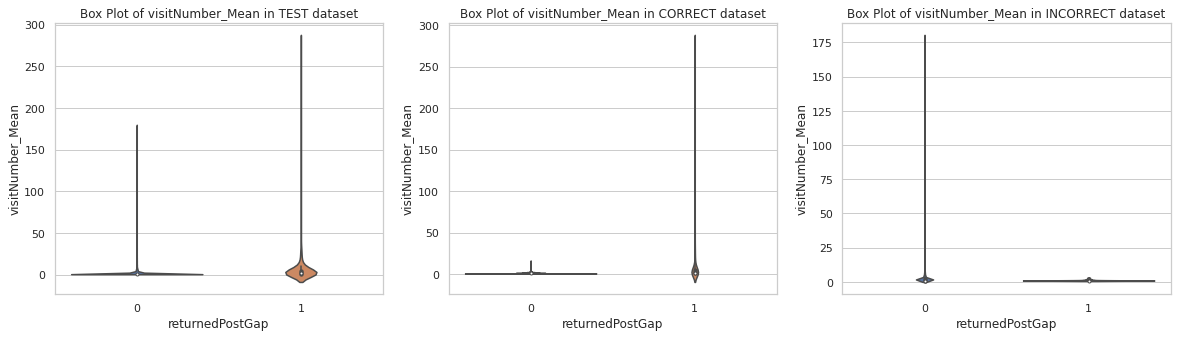

In [56]:
get_insights("visitNumber_Mean")

<font color="#a020f0">Observations:-
* As is evident from the shape of pdf (the spread) of mean visit number in parent TEST dataset, most class-0 visitors had mean visit number revolving around 0-2 and a fewer class-1 visitors had mean visit number revolving around 0-2.
* This is almost the same scenario in the CORRECT dataset also, only difference being: the density of customers in mean visit number range 0-2 have reduced considerably in class-1 here. Reason for this is the model declared most of these customers as belonging to class-0 (as is evident from the INCORRECT dataset's class-0 plot; it is bit less spread as compared to how it should've been). Vice-versa is the case with class-1 (spread of pdf has increased in class-1 here).</font>

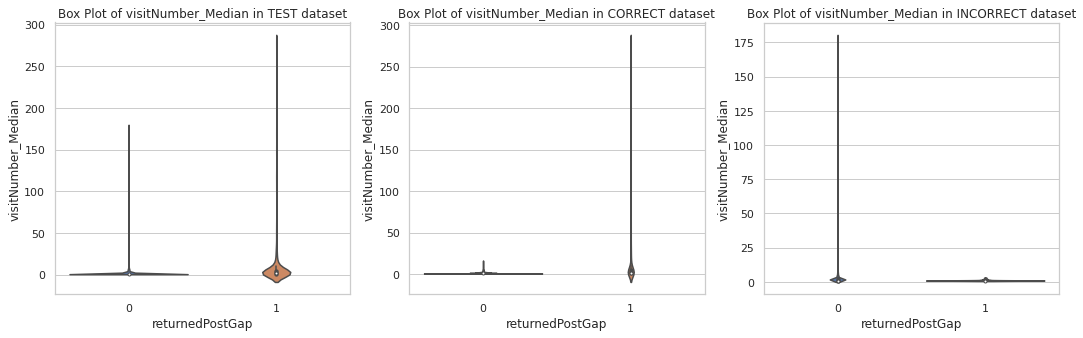

In [33]:
get_insights("visitNumber_Median")

<font color="#a020f0">Observations:-
* Visit number's median has the same observations as its mean.
* The intense similarity b/w these 2 plots represent that visit number feature has no outliers and hence, ahve same distributions throughout the datasets.</font>

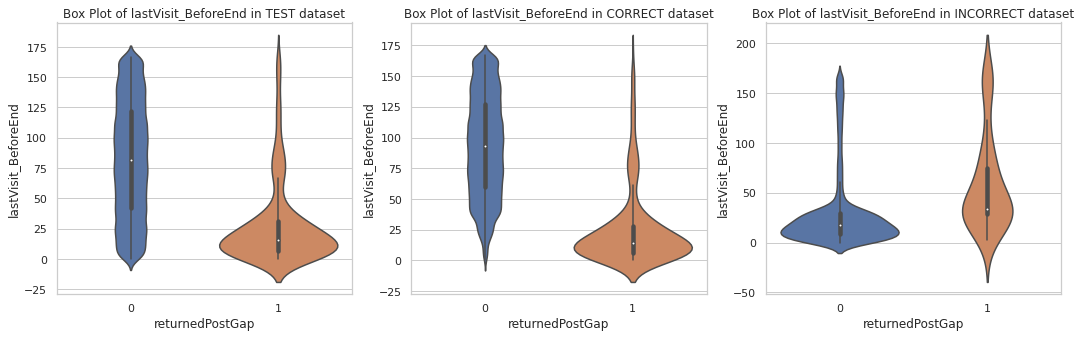

In [34]:
get_insights("lastVisit_BeforeEnd")

<font color="#a020f0">This feature indicates what was the no. of days before which the customer visited last, before the end of pre-gap period this customer falls in. Observations:-
* These plots are beautiful! 😃 Distinction is clear from shapes of the PDFs!
* In TEST dataset the PDF of :-
  * class-0 --> evenly shaped throughout.
  * class-1 --> thick from 0-50; tapered from 50-175.
* In CORRECT dataset the PDF of:-
  * class-0 --> tapered from 0-30; rest is same as TEST dataset.
  * class-1 --> a bit less thick from 0-50; rest is same as TEST dataset.
* In INCORRECT datset, reason why:-
  * class-0 pdf is thick from 0-25 and class-1 is very narrow from 0-50 is --> the model got confused here and declared class 1 as 0 and vice-versa.
* THE MOST CLEAR DISTINCTION IS: similar medians in class-0 (approx. 75), class-1 (approx.15) b/w TEST & CORRECT plots, but just the reverse medians in INCORRECT plot (class-0 has median similar to class-1's actual median :approx. 15 & vice-versa).</font>

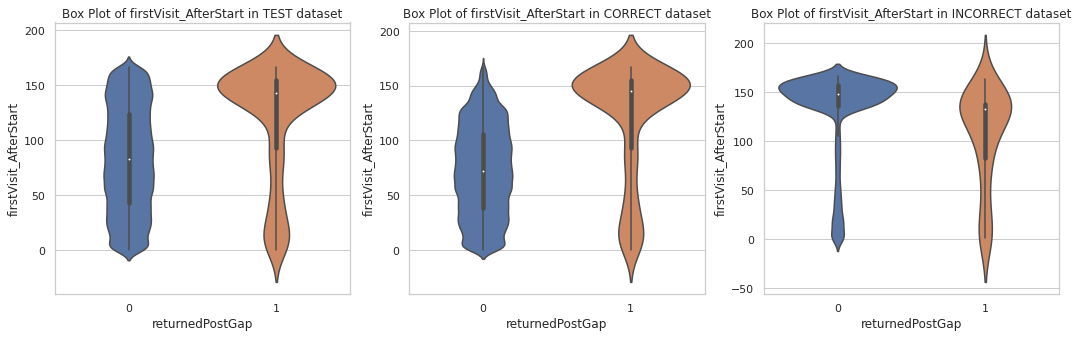

In [35]:
get_insights("firstVisit_AfterStart")

<font color="#a020f0">This is the frst visit that a customer made after the start of the pre-gap period this customer falls in. Observations:-
* Same as last visit before end; only difference being, the confusion has occurred for points mostly falling in 130-150 for class-0 and 100-130 for class-1.
* THE MOST CLEAR DISTINCTION IS: similar medians in class-0 (approx. 75), class-1 (approx.150) b/w TEST & CORRECT plots, but just the reverse medians in INCORRECT plot (class-0 has median similar to class-1's actual median :approx. 150 & vice-versa).</font>

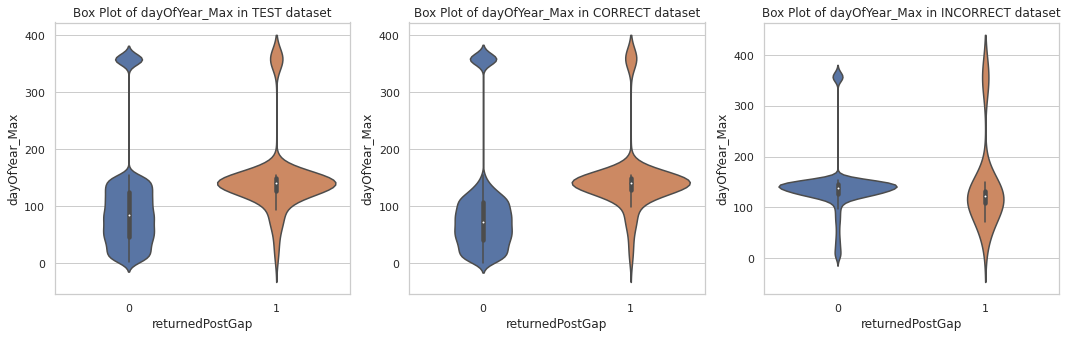

In [39]:
get_insights("dayOfYear_Max")

<font color="#a020f0">This is the last day number on which a customer visited. Observations:-
* Looking at the shapes of PDFs across the 2 classes across all 3 datsets, this is again similar to the 2 previously analysed features.
* PDFs for class-0 in CORRECT dataset's plot is similar to TEST from 0-100, but tapered from 100-150 approx. These points have been declared as class-1 (as is evident from the INCORRECT datatset's plot).
* What's more clear is: the PDF's have reversed their shapes in b/w CORRECT & INCORRECT datasets' plots.
* THE MOST CLEAR DISTINCTION IS: similar medians in class-0 (approx. 80), class-1 (approx. 120) b/w TEST & CORRECT plots, but just the reverse medians in INCORRECT plot (class-0 has median similar to class-1's actual median :approx. 120 & vice-versa).</font>

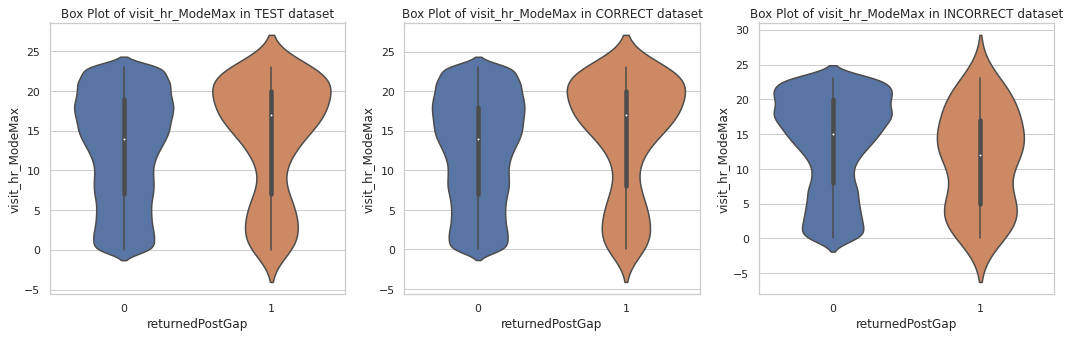

In [45]:
get_insights("visit_hr_ModeMax")

<font color="#a020f0">This is the hour of the day on which a customer visited the most. Observations:-
* Looking at the shapes of PDFs across the 2 classes across all 3 datsets, this is again similar to the previously analysed features.
* THE MOST CLEAR DISTINCTION IS: similar medians in class-0 (approx. 13), class-1 (approx. 18) b/w TEST & CORRECT plots, but just the reverse medians in INCORRECT plot (class-0 has median similar to class-1's actual median :approx. 14 & vice-versa).</font>

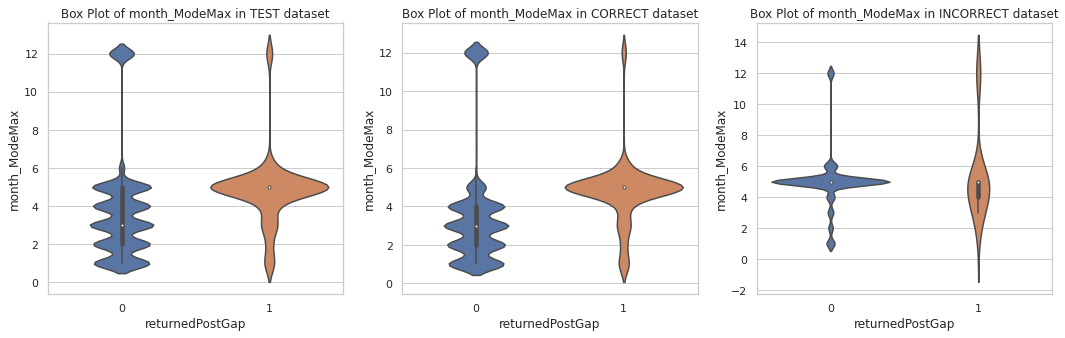

In [44]:
get_insights("month_ModeMax")

<font color="#a020f0">This is the month of a year on which a customer visited the most. Observations:-
* Looking at the shapes of PDFs across the 2 classes across all 3 datsets, this is again similar to the previously analysed features.
* THE MOST CLEAR DISTINCTION IS: similar medians in class-0 (approx. 3), class-1 (approx. 5) b/w TEST & CORRECT plots, but just the reverse medians in INCORRECT plot (class-0 has median similar to class-1's actual median :approx. 5 & vice-versa).</font>